In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt
from shape_synthesis.plotting.plot2d import plot_point_clouds_grid_2d

from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
from shape_synthesis.datasets.transforms import get_transform 


from shape_synthesis.datasets.mnist import DataConfig, create_dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# When turning dev=True, the dataset will be created with a smaller number of points for faster testing
num_pts = 256
dev = False
res = 32
num_dir = 16
num_examples = 10000

x_dim  = res * num_dir 

hidden_dim = 400
latent_dim = 100

hidden_dims_mlp = [64, 128, 256]

lr_vae = 1e-3
lr_mlp = 1e-3
batch_size = 64
epochs_vae = 150
epochs_mlp = 100

config = DataConfig(
        root="./data",
        raw="./data/raw",
        num_pts=num_pts,
        module="datasets.mnist",
        batch_size=None,
    )

prod
Creating: ./data/mnist
Creating: ./data/raw
Saving config to ./data/mnist/prod/config.yaml
Info
Min tensor([-0.7842, -0.7776])
Max tensor([0.6302, 0.6388])
Norm tensor(0.9034)
Info
Min tensor([-0.7842, -0.7776])
Max tensor([0.6302, 0.6388])
Norm tensor(0.9034)


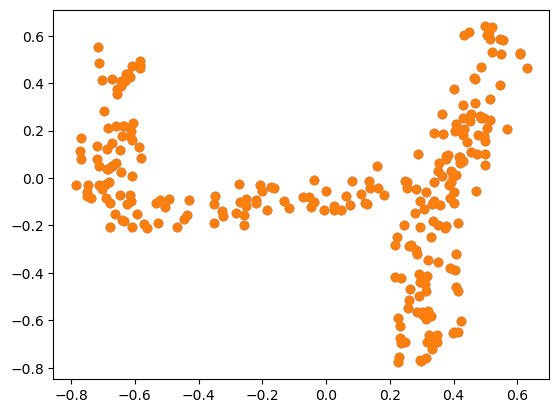

In [2]:
create_dataset(config, dev=dev)

if dev:
    train_pts = torch.load("./data/mnist/dev/train.pt")
    train_imgs = torch.load("./data/mnist/dev/train_imgs.pt")
else:
    train_pts = torch.load("./data/mnist/prod/train.pt")[:num_examples]
    train_imgs = torch.load("./data/mnist/prod/train_imgs.pt")[:num_examples]

x = train_pts[2]
plt.scatter(x[:, 0], x[:, 1])

print(72 * "=")
print("Info")
print("Min", x.min(dim=0)[0])
print("Max", x.max(dim=0)[0])
print("Norm", torch.norm(x, dim=1).max())
print(72 * "=")

x = train_pts[2]
plt.scatter(x[:,0],x[:,1])


print(72*"=")
print("Info")
print("Min", x.min(dim=0)[0])
print("Max", x.max(dim=0)[0])
print("Norm", torch.norm(x,dim=1).max())
print(72*"=")

In [3]:
print("Shape of train_pts:", train_pts.shape)

Shape of train_pts: torch.Size([10000, 256, 2])


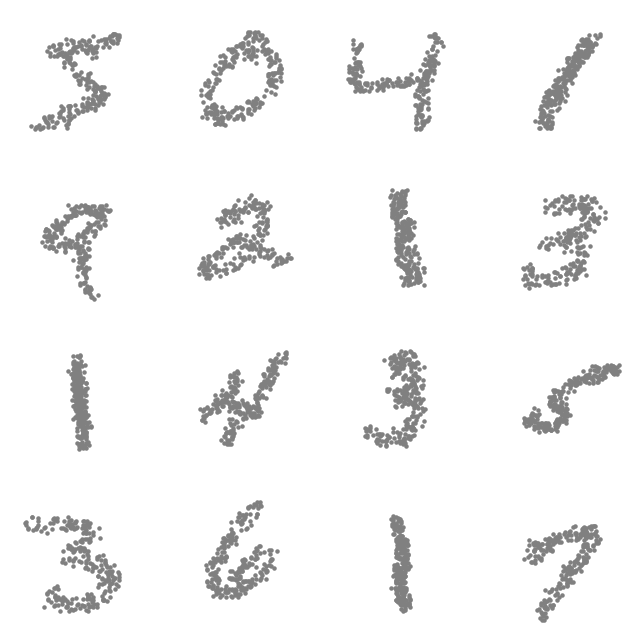

In [4]:
fig = plot_point_clouds_grid_2d(train_pts[:16])

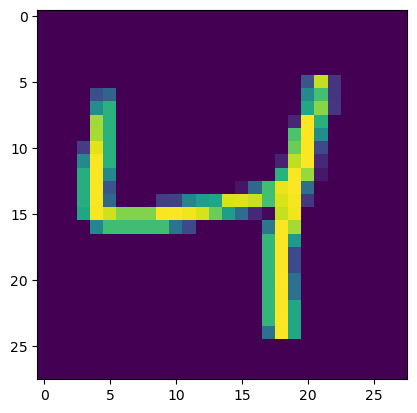

In [5]:
plt.imshow(train_imgs[2])

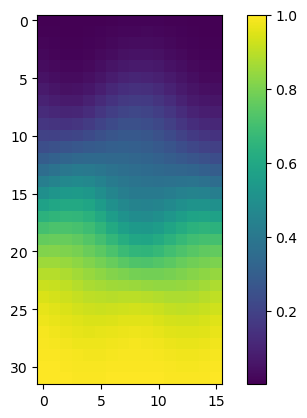

In [6]:
transform = get_transform(device=DEVICE, resolution=res, num_thetas=num_dir)

ect = transform(train_pts[:10])
plt.imshow(ect[2].cpu().numpy())
plt.colorbar()

### Create Dataset and DataLoader

In [7]:
transform = get_transform(device=DEVICE, resolution=res, num_thetas=num_dir)
ect = transform(train_pts).movedim(-1,-1)
ect_tensor = torch.flatten(ect, start_dim=1)
labels = train_pts

full_dataset = TensorDataset(ect_tensor, train_pts)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

In [8]:
print(train_pts.shape)
print(ect_tensor.shape)

torch.Size([10000, 256, 2])
torch.Size([10000, 512])


### Add VAE

In [9]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [11]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [31]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Define loss and optimizer

In [32]:
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var, epoch_coeff):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + 0.1 * KLD


optimizer = Adam(model.parameters(), lr=lr_vae)

In [33]:
print("Start training VAE...")
model.train()

for epoch in range(epochs_vae):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var, epoch/epochs_vae)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  181.6264873046875
	Epoch 2 complete! 	Average Loss:  172.5049064941406
	Epoch 3 complete! 	Average Loss:  172.2887869873047
	Epoch 4 complete! 	Average Loss:  172.2364608154297
	Epoch 5 complete! 	Average Loss:  172.21171728515625
	Epoch 6 complete! 	Average Loss:  172.16748205566407
	Epoch 7 complete! 	Average Loss:  172.1550821533203
	Epoch 8 complete! 	Average Loss:  172.13457177734375
	Epoch 9 complete! 	Average Loss:  172.10229174804687
	Epoch 10 complete! 	Average Loss:  171.97525659179686
	Epoch 11 complete! 	Average Loss:  171.9050692138672
	Epoch 12 complete! 	Average Loss:  171.77997595214845
	Epoch 13 complete! 	Average Loss:  171.67343676757812
	Epoch 14 complete! 	Average Loss:  171.63927697753905
	Epoch 15 complete! 	Average Loss:  171.56109350585936
	Epoch 16 complete! 	Average Loss:  171.4776241455078
	Epoch 17 complete! 	Average Loss:  171.43690063476564
	Epoch 18 complete! 	Average Loss:  171.42892175292968
	Epo

### Define and Train Decoder of the ECT

In [34]:
class PointCloudMLP(nn.Module):
    def __init__(self, x_input: int, hidden_dims: list, no_points: int):
        """
        Args:
            x_input (int): Dimension of input vector.
            hidden_dims (list): List of hidden layer sizes, e.g. [128, 256].
            no_points (int): Number of output points (point cloud size).
        """
        super(PointCloudMLP, self).__init__()
        
        # Build fully connected layers
        layers = []
        input_dim = x_input
        
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h

        # Final layer: outputting (no_points * 2) values
        layers.append(nn.Linear(input_dim, no_points * 2))
        
        self.network = nn.Sequential(*layers)
        self.no_points = no_points

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, x_input).
        Returns:
            torch.Tensor: Output point cloud of shape (batch_size, no_points, 2).
        """
        out = self.network(x)  # (batch_size, no_points * 2)
        out = out.view(-1, self.no_points, 2)  # Reshape to (batch_size, no_points, 2)
        return out

In [16]:
# Add a loss function to allow permutation invariance

def chamfer_distance(p1, p2):
    """
    p1, p2: (batch, n, 2)
    """
    diff_1 = torch.cdist(p1, p2)  # (batch, n, n)
    min_dist_1 = diff_1.min(dim=2)[0]  # (batch, n)
    min_dist_2 = diff_1.min(dim=1)[0]  # (batch, n)
    return (min_dist_1.mean() + min_dist_2.mean())

In [17]:
x_input = res*num_dir
model2 = PointCloudMLP(x_input, hidden_dims_mlp, num_pts)

optimizer = Adam(model2.parameters(), lr=lr_mlp)
loss_fn = chamfer_distance

for epoch in range(epochs_mlp):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(batch_size, x_input)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        y_hat = model2(x)
        loss = loss_fn(y, y_hat)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))

	Epoch 1 complete! 	Average Loss:  0.0019284105757251381
	Epoch 2 complete! 	Average Loss:  0.0016923713404685258
	Epoch 3 complete! 	Average Loss:  0.001524628239683807
	Epoch 4 complete! 	Average Loss:  0.0013860028320923448
	Epoch 5 complete! 	Average Loss:  0.0013080824725329877
	Epoch 6 complete! 	Average Loss:  0.0012385484809055924
	Epoch 7 complete! 	Average Loss:  0.0011822732584550978
	Epoch 8 complete! 	Average Loss:  0.0011575472466647625
	Epoch 9 complete! 	Average Loss:  0.0011425163559615611
	Epoch 10 complete! 	Average Loss:  0.0011325831776484846
	Epoch 11 complete! 	Average Loss:  0.001116775839589536
	Epoch 12 complete! 	Average Loss:  0.0011113349832594394
	Epoch 13 complete! 	Average Loss:  0.001104090392589569
	Epoch 14 complete! 	Average Loss:  0.0010942846182733774
	Epoch 15 complete! 	Average Loss:  0.0010880882507190107
	Epoch 16 complete! 	Average Loss:  0.0010828991020098329
	Epoch 17 complete! 	Average Loss:  0.0010712284063920379
	Epoch 18 complete! 	Avera

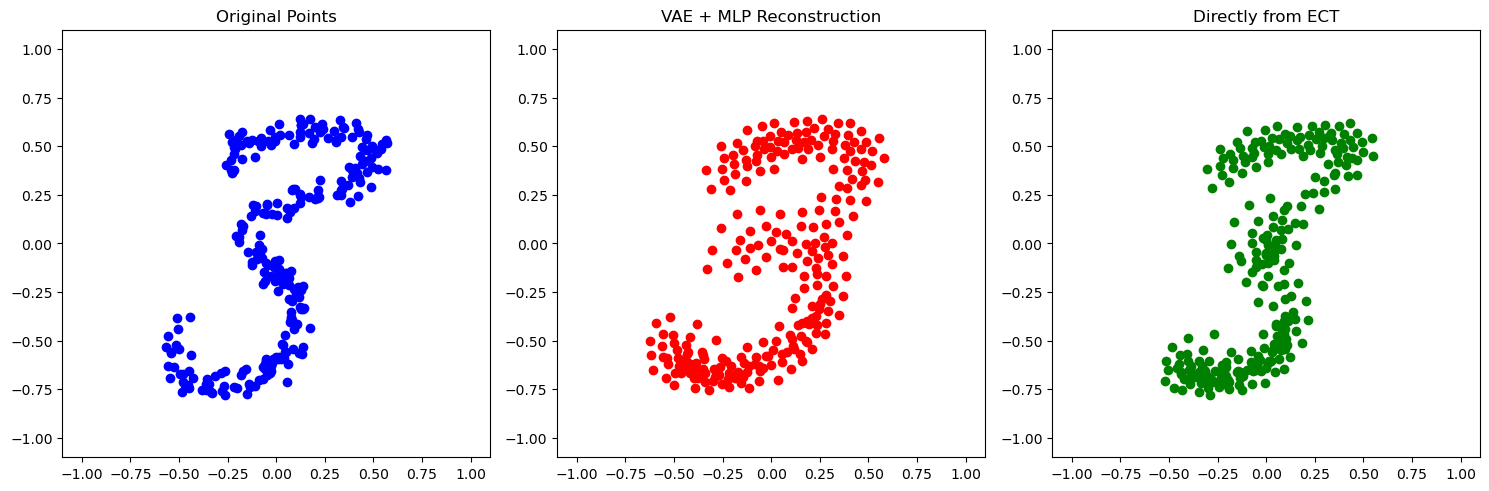

In [40]:
idx = 22

for batch_idx, (x, y) in enumerate(test_loader):
    if batch_idx == 0:
        x = x.view(batch_size, x_dim).to(DEVICE)

        optimizer.zero_grad()

        with torch.no_grad():
            x_hat, _, _ = model(x)
            y_hat = model2(x_hat)
            x_from_ect = model2(x)

        test_ect = x
        test_cloud = y

        # ---- Create 3 side-by-side plots ----
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original
        axes[0].scatter(y[idx, :, 0].cpu(), y[idx, :, 1].cpu(), color='blue')
        axes[0].set_title("Original Points")
        axes[0].set_aspect("equal")

        # VAE + MLP
        axes[1].scatter(y_hat[idx, :, 0].cpu(), y_hat[idx, :, 1].cpu(), color='red')
        axes[1].set_title("VAE + MLP Reconstruction")
        axes[1].set_aspect("equal")

        # Directly from ECT
        axes[2].scatter(x_from_ect[idx, :, 0].cpu(), x_from_ect[idx, :, 1].cpu(), color='green')
        axes[2].set_title("Directly from ECT")
        axes[2].set_aspect("equal")

        # Optional: Keep same axis limits for comparability
        for ax in axes:
            ax.set_xlim([-1.1, 1.1])
            ax.set_ylim([-1.1, 1.1])

        plt.tight_layout()
        plt.show()

    else:
        break

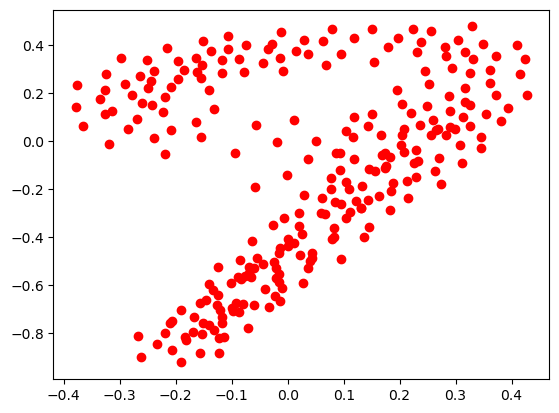

In [41]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)
    generated_images = model2(generated_images)
    plt.scatter(generated_images[idx, :, 0].cpu(), generated_images[idx, :, 1].cpu(), color='red', label='Generated Points')